# MLBにおけるストライクゾーンの推定＆可視化

In [1]:
import numpy as np
import pandas as pd

from pybaseball import statcast

from plotnine import *
from dfply import *
import math

## データ取得

In [2]:
# Statcast pitch-by-pitch data on all regular season games in 2019
mlb2019 = statcast(start_dt="2019-03-28", end_dt="2019-04-30")

This is a large query, it may take a moment to complete


100%|██████████| 34/34 [00:21<00:00,  1.58it/s]


In [5]:
# 欠損値除去＆変数作成
mlb = (
    mlb2019
    >> filter_by(X.plate_x.notnull())
    >> filter_by(X.plate_z.notnull())
    >> filter_by(X.sz_top.notnull())
    >> filter_by(X.sz_bot.notnull())
    >> mutate(code=if_else(X.description == "called_strike", "Called Strike", "Ball"))
    >> mutate(code2=if_else(X.code == "Called Strike", 1, 0))
)

In [6]:
# 概観
mlb.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,code,code2
2807,SI,2019-04-30,97.4,3.51,5.13,"Hader, Josh",448602,623352,strikeout,foul_tip,...,4,3,4,Strategic,Standard,151,0.035,-0.081,Ball,0
2970,SI,2019-04-30,95.8,3.52,5.1,"Hader, Josh",448602,623352,NaN,called_strike,...,4,3,4,Strategic,Standard,152,0.0,-0.028,Called Strike,1
3020,SI,2019-04-30,94.4,3.41,5.13,"Hader, Josh",448602,623352,NaN,foul,...,4,3,4,Strategic,Standard,149,0.0,-0.021,Ball,0
3153,SI,2019-04-30,95.1,3.49,5.2,"Hader, Josh",448602,623352,NaN,ball,...,4,3,4,Strategic,Standard,152,0.0,0.015,Ball,0
3204,SI,2019-04-30,95.4,3.31,5.19,"Hader, Josh",435622,623352,home_run,hit_into_play,...,4,3,4,Standard,Standard,154,-0.023,1.801,Ball,0


## 投球分布

In [5]:
# 見逃しかつファストボールに絞る＆重いのでランダムサンプリングしとく
dist = (
    mlb
    >> filter_by(X.pitch_type == "FF")
    >> filter_by((X.description == "called_strike") | (X.description == "ball"))
    >> sample(n=10000)
)

# ルールブック上のストライクゾーン
# 上限と下限は打者平均とする．なお，ホームプレート＝17インチ，ボール＝9インチ（1インチ＝1/12フィート）．
plate_width = (17 + 2 * (9 / math.pi)) / 12
xm = [
    -(plate_width / 2),
    plate_width / 2,
    plate_width / 2,
    -(plate_width / 2),
    -(plate_width / 2),
]
zm = [
    dist["sz_bot"].mean(),
    dist["sz_bot"].mean(),
    dist["sz_top"].mean(),
    dist["sz_top"].mean(),
    dist["sz_bot"].mean(),
]
sz_mlb = pd.DataFrame({"xm": xm, "zm": zm})

C:\Users\ksk01\AppData\Roaming\Python\Python39\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 252 rows containing missing values.


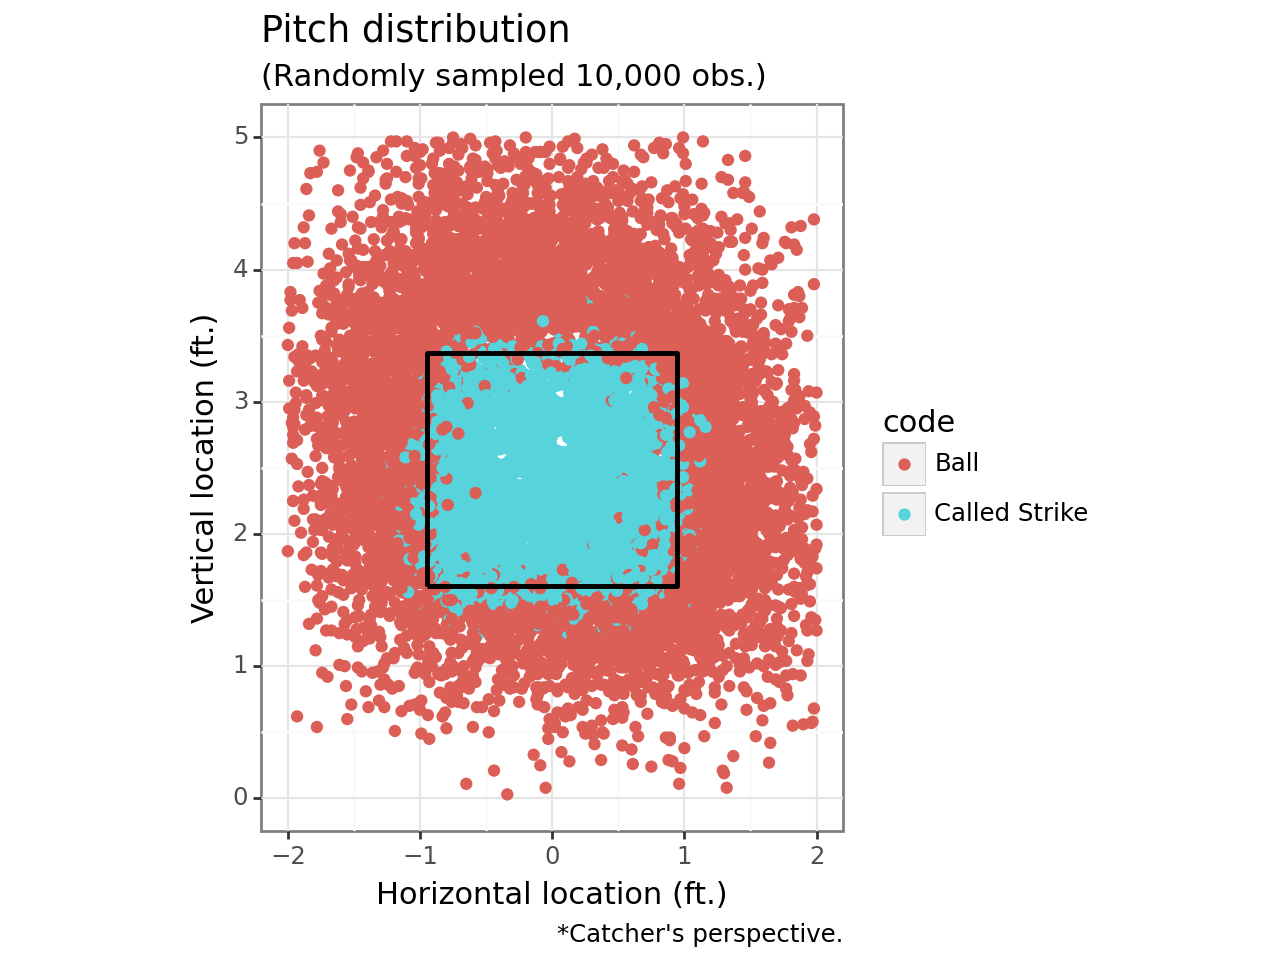

<Figure Size: (640 x 480)>

In [72]:
# 可視化
pdist = (
    ggplot(dist, aes(x="plate_x", y="plate_z"))
    + geom_point(aes(color="code"), alpha=1.0)
    + geom_path(sz_mlb, aes(x="xm", y="zm"), linejoin="round", size=1.0)
    + coord_equal()
    + scale_x_continuous(name="Horizontal location (ft.)", limits=(-2.0, 2.0))
    + scale_y_continuous(name="Vertical location (ft.)", limits=(0.0, 5.0))
    + labs(
        title="Pitch distribution",
        subtitle="(Randomly sampled 10,000 obs.)",
        caption="*Catcher's perspective.",
    )
    + theme_bw()
)
pdist

## ストライクゾーンの推定

In [7]:
from sklearn.svm import SVC

In [12]:
y = mlb["code2"]
X = mlb[["plate_x", "plate_z"]]
y, X

(2807    0
 2970    1
 3020    0
 3153    0
 3204    0
        ..
 3506    0
 3604    0
 3714    0
 3898    1
 3933    0
 Name: code2, Length: 129688, dtype: int32,
       plate_x  plate_z
 2807    -0.28     2.54
 2970    -0.47     2.73
 3020     1.15     2.66
 3153     0.83     0.97
 3204    -0.69     2.17
 ...       ...      ...
 3506    -0.39     1.17
 3604    -0.77     3.41
 3714     0.12     0.42
 3898     0.89     2.76
 3933    -0.34     1.88
 
 [129688 rows x 2 columns])

In [13]:
# Fit SVM
svc = SVC()
svc.fit(X, y)

SVC()

In [26]:
# grid
pred_area = pd.DataFrame(
    [(x, y) for x in np.arange(-2, 2, 0.01) for y in np.arange(0, 5, 0.01)],
    columns=["plate_x", "plate_z"],
)
pred_area.head()

,plate_x,plate_z
0,-2.0,0.00
1,-2.0,0.01
2,-2.0,0.02
3,-2.0,0.03
4,-2.0,0.04


In [33]:
# prediction
# pred_area = # grid
pred_area_fit_svm = pd.DataFrame(svc.predict(pred_area), columns=["pred"])

In [37]:
pred_area_fit_svm.head()

,pred
0,0
1,0
2,0
3,0
4,0


In [42]:
fit_svm = pd.concat([pred_area, pred_area_fit_svm], axis=1)
fit_svm.head()

,plate_x,plate_z,pred
0,-2.0,0.00,0
1,-2.0,0.01,0
2,-2.0,0.02,0
3,-2.0,0.03,0
4,-2.0,0.04,0


In [43]:
fit_svm.shape

(200000, 3)